In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
dir = "../DL-Project/"

def load(i):
    data = np.load(dir+f'data{i}.npy')
    label = np.load(dir+f'lab{i}.npy')
    return data,label

data0,lab0 = load(0)
data1,lab1  = load(1)
data2,lab2  = load(2)

data = np.concatenate([data0, data1, data2], axis=0)
labels = np.concatenate([lab0, lab1, lab2], axis=0)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)


In [8]:
class Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

train_dataset = Dataset(train_data, train_labels, transform=transform)
val_dataset = Dataset(val_data, val_labels, transform=transform)
test_dataset = Dataset(test_data,test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [10]:
saved_model_path = 'resnet_step.pth'  # Path to the saved model
model = torch.load(saved_model_path)  # Load the entire model
model.eval()  # Set the model to evaluation mode


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Ensure the model is on the correct device
model = model.to(device)

# Test the loaded model
evaluate_model(model, test_loader)

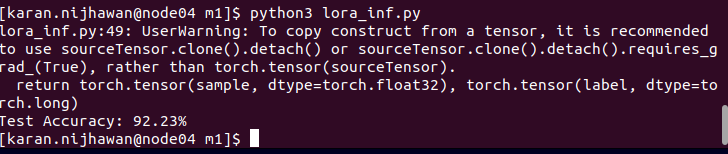